# MCMC analysis of cosmological FRB constraints using the Pade Approximants

**Note**: This notebook uses the updated formalism developed for Zhuge+ (2025) [[here](https://arxiv.org/abs/2508.05161)].

## Run properties and loading modules

In [1]:
### If the MCMC functions need to be imported from a file, this should be OFF
## Depends on how the OS handles multiprossecing
RUN_IN_NOTEBOOK = True

SAVE_DATA = False
SAVE_FIG = False

In [2]:
import sys
sys.path.append('../Python_scripts')
# sys.path.append('./interpolation')
DATA_PATH = './interpolation/095_C0mean.npz'

### Import packages
from config import *
from support import *
from cosmo_support import *
from mcmc_support import *

In [3]:
## Plotting
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

## Generate data

In [29]:
## Number of random events
N_EVENTS = 50

## Minimum redshift
z_min = 0.25


z_centres, DM_centres, DM_obs_centre, s_DM_obs = generate_events(N_EVENTS, z_min, method='Gaussian', error_size=0.2, data_path=DATA_PATH)

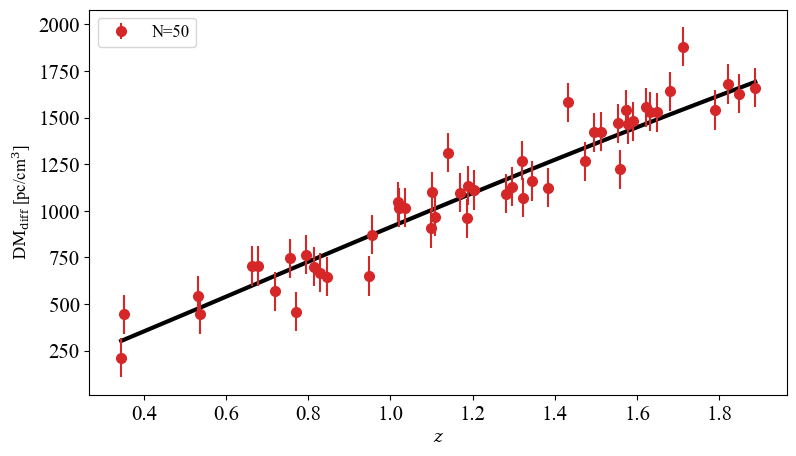

In [30]:
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)

ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='black', lw=3)
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=7, c='tab:red', label=f'N={N_EVENTS}')


ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)

plt.show()

# Run MCMC analysis

In [31]:
samples, flat_samples = run_mcmc_analysis(z_centres, DM_obs_centre, s_DM_obs, log_probability_frb, N_samples=15000)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [17:15<00:00, 14.49it/s]


In [32]:
samples_PD, flat_samples_PD = run_mcmc_analysis(z_centres, DM_obs_centre, s_DM_obs, log_probability_frb_Pade, N_samples=15000)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:39<00:00, 376.27it/s]


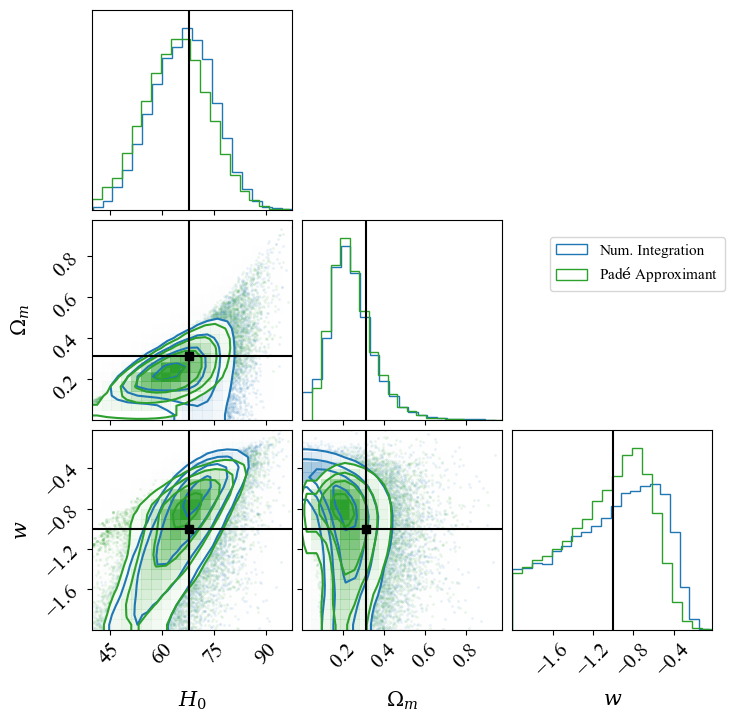

In [33]:
labels = [r"$H_0$", r"$\Omega_m$", r"$w$"]

fig = corner.corner(
    flat_samples, labels=labels, color="tab:blue", smooth=True, label_kwargs={"fontsize": 15},
)
corner.corner(
    flat_samples_PD, fig=fig, truths=[HUBBLE, OMEGA_MATTER, W_LAMBDA], truth_color='black', color="tab:green", smooth=True
);

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=15)

plt.legend(['Num. Integration', r'Pad$\'{\rm e}$ Approximant'], loc='upper right', bbox_to_anchor=(0.1, 1., 1, 1), fontsize=11)
plt.show()

-----------------------------------------------------------------------------

# MCMC results investigation

## Chains

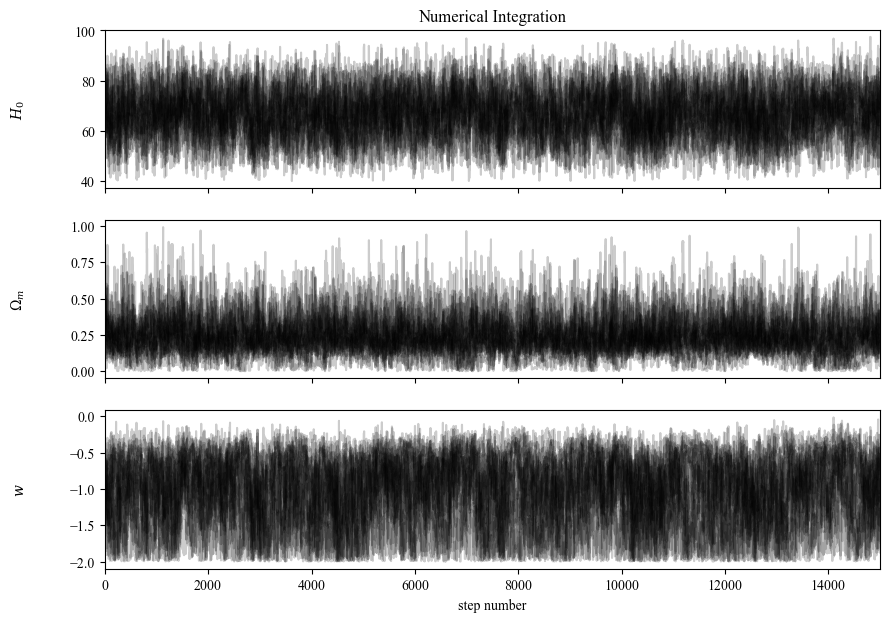

In [34]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

for idx, name in enumerate(labels):
    ax = axes[idx]
    ax.plot(samples[:, :, idx], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(name)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[0].set_title('Numerical Integration')

plt.show()

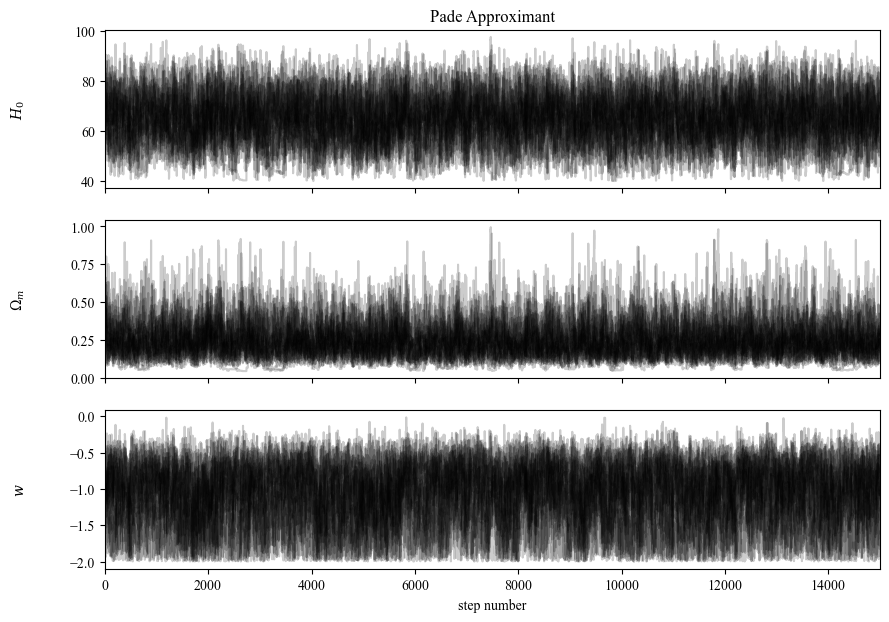

In [35]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [r"$H_0$", r"$\Omega_m$", r"$w$"]
for idx, name in enumerate(labels):
    ax = axes[idx]
    ax.plot(samples_PD[:, :, idx], "k", alpha=0.2)
    ax.set_xlim(0, len(samples_PD))
    ax.set_ylabel(name)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[0].set_title('Pade Approximant')

plt.show()

## Individual corner plots

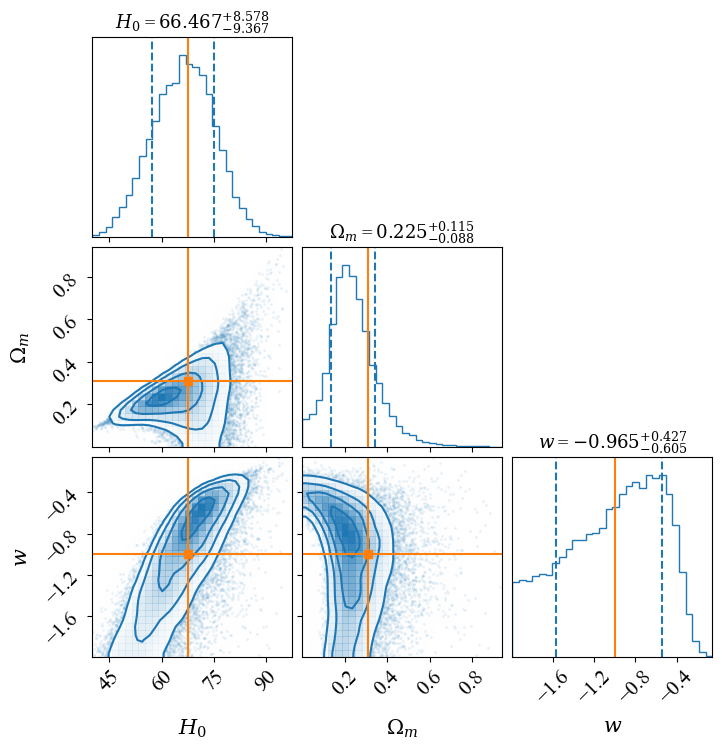

In [36]:
mcmc_plot_results(flat_samples, labels, [HUBBLE, OMEGA_MATTER, W_LAMBDA])

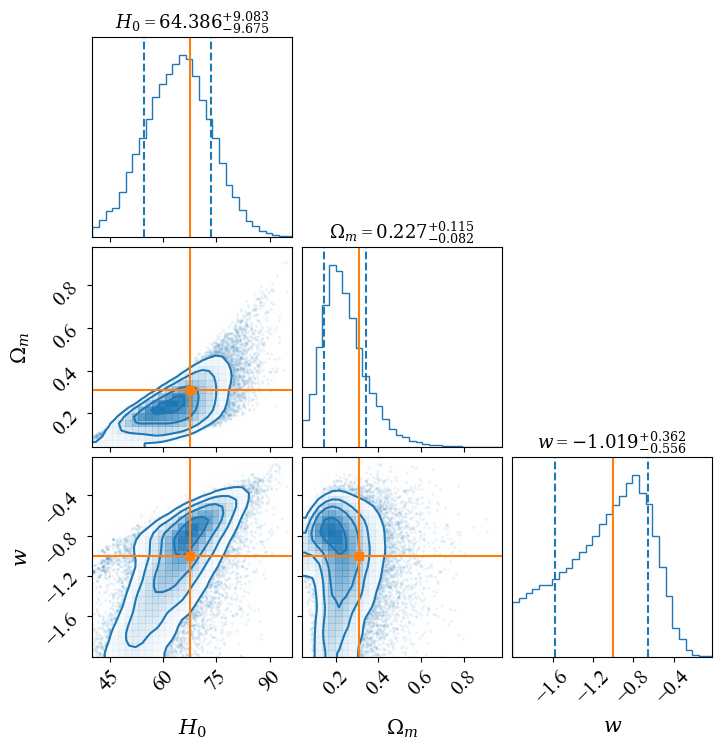

In [37]:
mcmc_plot_results(flat_samples_PD, labels, [HUBBLE, OMEGA_MATTER, W_LAMBDA])

## Posterior predictive checks

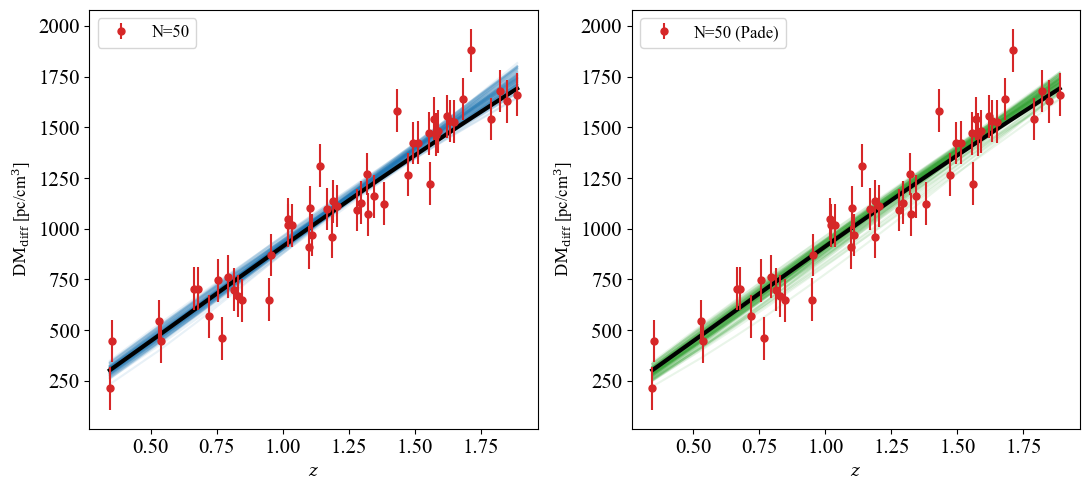

In [38]:
inds = rng.integers(len(flat_samples), size=100)

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for ind in inds:
    sample = flat_samples[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax1.plot(np.sort(z_centres), DM_i, "tab:blue", alpha=0.1)
ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='black', lw=3)
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='tab:red', label=f'N={N_EVENTS}')

ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)


for ind in inds:
    sample = flat_samples_PD[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax2.plot(np.sort(z_centres), DM_i, "tab:green", alpha=0.1)
ax2.plot(np.sort(z_centres), np.sort(DM_centres), c='black', lw=3)
ax2.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='tab:red', label=f'N={N_EVENTS} (Pade)')

ax2.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax2.set_xlabel(r'$z$', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()